In [30]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.unet import *
from torch import nn
from PIL import Image as PILImage

import json

torch.backends.cudnn.benchmark=True

torch.cuda.is_available()

True

In [31]:
import os
print(os.listdir("data"))

['sample_submission.csv', 'train', 'test_128', 'tmp', 'models', 'test', 'train_layered', '.~lock.train.csv#', 'test_layered', 'train_128', 'train.csv']


# Setup Data

In [32]:
from sklearn.model_selection import train_test_split

PATH = Path('data')
train_df = pd.read_csv(PATH/'train.csv')

trn_ids = [o for o in train_df.Id]
trn_targs = [o for o in train_df.Target]

## Make Layered Data

In [33]:
band_names = ['_red.png','_green.png','_blue.png','_yellow.png']

In [34]:
(PATH/f'train_layered').mkdir(exist_ok=True)
(PATH/f'test_layered').mkdir(exist_ok=True)

In [35]:
# %%time

# for img_id in trn_ids:
#     img_bands=[]
#     for band_name in band_names:
#         p = f'data/train/{img_id + band_name}'            
#         pil_channel = PILImage.open(p)
#         img_bands.append(pil_channel)
        
#     img_bands = PILImage.merge('RGBA', bands=img_bands)
#     img_bands.save(PATH/f'train_layered/{img_id}.png')

In [36]:
list(os.listdir('data/test'))[0][:-4]

'f26eecb2-bacd-11e8-b2b8-ac1f6b6435d0_blue'

In [37]:
# %%time

# for img_id in list((PATH/'test').iterdir()):
#     img_bands=[]
#     for band_name in band_names:
#         p = f'data/test/{img_id + band_name}'            
#         pil_channel = PILImage.open(p)
#         img_bands.append(pil_channel)
        
#     img_bands = PILImage.merge('RGBA', bands=img_bands)
#     img_bands.save(PATH/f'test_layered/{img_id}.png')

In [38]:
# img_bands=[]
# for band_name in band_names:
#     img_id = 'd9c397ac-bbc8-11e8-b2bc-ac1f6b6435d0'
#     p = f'data/train/{img_id + band_name}'            
#     pil_channel = PILImage.open(p)
#     img_bands.append(pil_channel)

# img_bands = PILImage.merge('RGBA', bands=img_bands)
# img_bands.save(PATH/f'train_layered/{img_id}.png')

# %%time

# def layer_train_img(fn):
#     img_bands=[]
#     for band_name in band_names:
#         p = f'data/train/{fn.name[:-4] + band_name}'            
#         pil_channel = PILImage.open(p)
#         img_bands.append(pil_channel)

#     img_bands = PILImage.merge('RGBA', bands=img_bands)
#     img_bands.save(PATH/f'train_layered/{fn.name}.png')

# files = list((PATH/'train').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(layer_train_img, files)

In [39]:
# %%time

# def layer_test_img(fn):
#     img_bands=[]
#     for band_name in band_names:
#         p = f'data/test/{fn + band_name}'            
#         pil_channel = PILImage.open(p)
#         img_bands.append(pil_channel)

#     img_bands = PILImage.merge('RGBA', bands=img_bands)
#     img_bands.save(PATH/f'test_layered/{fn}.png')

# files = list((PATH/'test').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(layer_test_img, files)

## Resize only

In [40]:
# def resize_train_img(fn):
#     Image.open(fn).resize((sz,sz)).save(PATH/f'train_{sz}'/fn.name)

# files = list((PATH/'train').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(resize_train_img, files)

In [41]:
# def resize_test_img(fn):
#     Image.open(fn).resize((sz,sz)).save(PATH/f'test_{sz}'/fn.name)

# files = list((PATH/'test').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(resize_train_img, files)

# Setup K Folds

In [42]:
from sklearn.model_selection import train_test_split, StratifiedKFold , KFold

folds = 5
kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

train_folds_x = []
train_folds_y = []
val_folds_x = []
val_folds_y = []

for idxs in kfold.split(train_df):
    train_folds_x.append([train_df.iloc[idx]['Id'] for idx in idxs[0]])
    train_folds_y.append([train_df.iloc[idx]['Target'] for idx in idxs[0]])
    val_folds_x.append([train_df.iloc[idx]['Id'] for idx in idxs[1]])
    val_folds_y.append([train_df.iloc[idx]['Target'] for idx in idxs[1]])

In [43]:
len(train_folds_x[0]), len(train_folds_y[0]), len(val_folds_x[0]), len(val_folds_y[0])

(24857, 24857, 6215, 6215)

In [44]:
def get_data_bunch(fold):
    trn_x = np.array([Path('train_layered')/f'{o}.png' for o in train_folds_x[fold]])
    trn_y = train_folds_y[fold]
    val_x = val_folds_x[fold]
    val_y = val_folds_y[fold] 
    return trn_x, trn_y, val_x, val_y

In [45]:
# def get_data_bunch(fold):
#     trn_x = np.array([Path('train_layered')/f'{o}.png' for o in train_folds_x[fold]])
#     trn_y = train_folds_y[fold]
#     val_x = np.array([Path('train_layered')/f'{o}.png' for o in val_folds_x[fold]])
#     val_y = val_folds_y[fold] 
#     return trn_x, trn_y, val_x, val_y

## Archive - train test split only 

In [46]:
# train, val = train_test_split(train_df, test_size=0.2)

# trn_x = list(train['Id'])
# trn_y = list(train['Target'])
# val_x = list(val['Id'])
# val_y = list(val['Target'])

In [47]:
#     trn_x = train_folds_x[fold]
#     trn_y = train_folds_y[fold]
#     val_x = val_folds_x[fold]
#     val_y = val_folds_y[fold]

# Construct Dataset

In [48]:
LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

## Primary Dataloader

In [49]:
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer

In [78]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
    
    def get_x(self, i): 
#         im = open_image(os.path.join(self.path, self.fnames[i]))
        im = Image.open(os.path.join(self.path, self.fnames[i]))
        im = np.array(im)
        return im 
        
    def get_y(self, i): 
        y = self.load_ohe(self.y[i])
        y = y.astype(float)
        return y
    
    def load_ohe(self, label_list):
        label_list = label_list.split(' ')
        label_list = self.mlb.fit_transform([[int(o) for o in label_list]])
        return label_list.squeeze()
    
    def get_c(self): return 0

## DataLoader Archive 

In [51]:
# class CustomDataset(BaseDataset):
#     def __init__(self, x, y, transform, size=128):
#         super().__init__(transform)
#         self.x = x
#         self.y = y
#         self.c = 28
#         self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
#         self.band_names = ['_red.png','_green.png','_blue.png','_yellow.png']
#         self.transform = transform
#         self.size = size
    
#     def __len__(self):
#         return len(self.x)
    
#     def get_n(self):
#         return 0
    
#     def get_x(self, i): 
#         img = self.load_img_array(self.x[i])
#         return img
    
#     def get_y(self, i): 
#         y = self.load_ohe(self.y[i])
#         y = y.astype(float)
#         return y
    
#     def load_img_array(self, img_id):
#         img_bands = []
        
#         for band_name in self.band_names:
#             p = f'data/train/{img_id + band_name}'            
#             pil_channel = PILImage.open(p)
#             img_bands.append(pil_channel)
        
#         img_bands = PILImage.merge('RGBA', bands=img_bands)
#         img_bands = np.array(img_bands, dtype='float32')
#         channeled = np.transpose(img_bands, (2, 1, 0))
#         return channeled
        
#     def load_ohe(self, label_list):
#         label_list = label_list.split(' ')
#         label_list = self.mlb.fit_transform([[int(o) for o in label_list]])
#         return label_list.squeeze()
    
#     def get_c(self): return 28
    
#     def get_sz(self): return self.transform.sz

In [52]:
# class CustomDataset(BaseDataset):
#     def __init__(self, x, y, transform, size=128):
#         super().__init__(transform)
#         self.x = x
#         self.y = y
#         self.c = 28
#         self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
#         self.band_names = ['_red.png','_green.png','_blue.png','_yellow.png']
#         self.transform = transform
#         self.size = size
    
#     def __len__(self):
#         return len(self.x)
    
#     def get_n(self):
#         return 0
    
#     def get_x(self, i): 
#         img = self.load_img_array(self.x[i])
#         return img
    
#     def get_y(self, i): 
#         y = self.load_ohe(self.y[i])
#         y = y.astype(float)
#         return y
    
#     def load_img_array(self, img_id):
#         img_bands = []
        
#         for band_name in self.band_names:
#             p = f'data/train/{img_id + band_name}'            
#             pil_channel = PILImage.open(p)
#             img_bands.append(pil_channel)
        
#         img_bands = PILImage.merge('RGBA', bands=img_bands)
#         img_bands = np.array(img_bands, dtype='float32')
#         channeled = np.transpose(img_bands, (2, 1, 0))
#         return channeled
        
#     def load_ohe(self, label_list):
#         label_list = label_list.split(' ')
#         label_list = self.mlb.fit_transform([[int(o) for o in label_list]])
#         return label_list.squeeze()
    
#     def get_c(self): return 28
    
#     def get_sz(self): return self.transform.sz
    
# #     def __getitem__(self, i):
# #         img = self.load_img_array(self.x[i])
# #         img = self.image_transform(img)
        
# #         y = self.load_ohe(self.y[i])
# #         y = y.astype(float)
# #         return img, y

In [53]:
# from sklearn.preprocessing import MultiLabelBinarizer

# class MatchedFilesDataset(FilesDataset):
#     def __init__(self, fnames, y, transform, path):
#         self.y=y
#         assert(len(fnames)==len(y))
#         super().__init__(fnames, transform, path)
#         self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
#         self.band_names = ['_red.png','_green.png','_blue.png','_yellow.png']
    
#     def get_x(self, i): 
#         img = self.load_img_array(self.fnames[i])
#         return img
        
#     def get_y(self, i): 
#         y = self.load_ohe(self.y[i])
#         y = y.astype(float)
#         return y
    
#     def load_ohe(self, label_list):
#         label_list = label_list.split(' ')
#         label_list = self.mlb.fit_transform([[int(o) for o in label_list]])
#         return label_list.squeeze()
    
#     def load_img_array(self, img_id):
#         img_bands = []

#         for band_name in self.band_names:
#             p = f'data/train/{img_id + band_name}'            
#             pil_channel = PILImage.open(p)
#             img_bands.append(pil_channel)

#         img_bands = PILImage.merge('RGBA', bands=img_bands)
#         img_bands = np.array(img_bands, dtype='float32')
#         channeled = np.transpose(img_bands, (2, 1, 0))
#         return channeled
    
#     def get_c(self): return 28

# Model Mk1 

In [54]:
class ch_resnet(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, x):
        x = self.base(x)
        return x

# Model functions

In [55]:
sz = 128
bs = 1

In [56]:
def get_base(cut):
    m = resnet34(pretrained=True)
    m.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    m.avgpool = nn.AdaptiveAvgPool2d(1)
    inft = m.fc.in_features
    m.fc = nn.Linear(in_features=inft, out_features=28)
    return m

class CustomModel():
    def __init__(self,model,lr_cut,name='unet'):
        self.model,self.name,self.lr_cut = model,name, lr_cut

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model), [self.lr_cut]))
        return [children(self.model)]

In [87]:
aug_tfms = [RandomFlip(tfm_y=None)]
tfms = tfms_from_model(ch_resnet, sz, 
               crop_type=CropType.NO, tfm_y=None, 
               aug_tfms=aug_tfms)

datasets=ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), 
                  (val_x, val_y), tfms=tfms, path=PATH)

md = ImageData(PATH, datasets, bs, num_workers=16, classes=28)

In [93]:
datasets[0].get_y(0).shape

(28,)

In [79]:
def get_learner(trn_x, trn_y, val_x, val_y, crit, sz=128, loaded=None):
    aug_tfms = [RandomFlip(tfm_y=None)]
#     aug_tfms = []
    tfms = tfms_from_model(ch_resnet, sz, 
                   crop_type=CropType.NO, tfm_y=None, 
                   aug_tfms=aug_tfms)

    datasets=ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), 
                      (val_x, val_y), tfms=tfms, path=PATH)

    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    f = resnet34
    cut,lr_cut = model_meta[resnet34]
    m_base = get_base(cut)
    m = to_gpu(ch_resnet(m_base))
    models = CustomModel(m, lr_cut)
    
    learn = ConvLearner(md, models)
    
    learn.opt_fn = optim.Adam
    learn.crit = crit
    return learn

# Test model

In [80]:
trn_x, trn_y, val_x, val_y = get_data_bunch(0)

In [81]:
learn = get_learner(trn_x, trn_y, val_x, val_y, nn.BCEWithLogitsLoss())

In [82]:
it = iter(learn.data.trn_dl)

In [83]:
x,y = next(it)

ValueError: operands could not be broadcast together with shapes (128,128,4) (3,) 

In [ ]:
x.shape

  0%|          | 0/24857 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (128,128,4) (3,) 

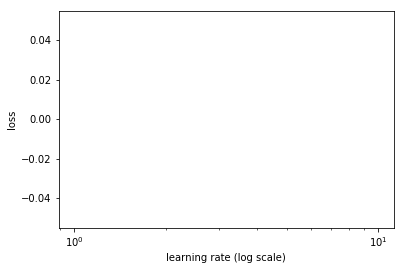

In [77]:
%time learn.lr_find()
learn.sched.plot()

  0%|          | 0/3108 [00:00<?, ?it/s]


AttributeError: 'MatchedFilesDataset' object has no attribute 'mlb'

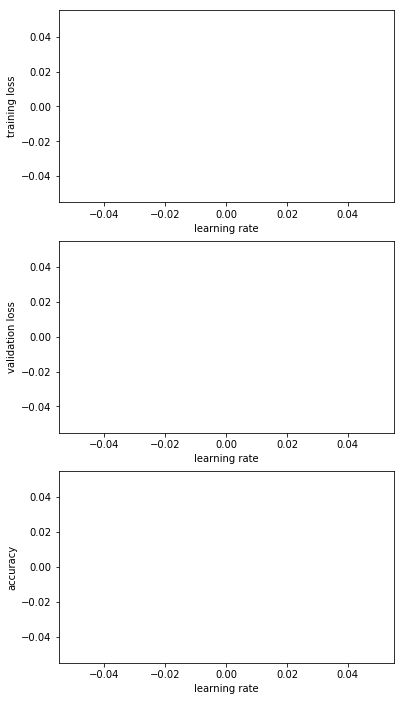

In [73]:
%time learn.lr_find2()
learn.sched.plot()

# Train model

In [39]:
lr = 1e-3

In [40]:
learn.fit(lr,1,wds=1e-7,cycle_len=10,use_clr_beta=(10,10, 0.85, 0.9), use_wd_sched=True, best_save_name='PA_Mk1base')

 70%|███████   | 2186/3108 [06:59<02:57,  5.21it/s, loss=0.131]

KeyboardInterrupt: 

# Submit

In [ ]:
test_fns = list(os.listdir('data/test'))

In [ ]:
submit = pd.read_csv('data/submission.csv')